# Final Project: Impact of NBA Games on Chicago Traffic Accidents Analysis
## Yuhuan Jiang

#### Download Traffic Crashes Dataset from Chicago Data Portal - Traffic Crashes from Mar 3, 2013 to Nov 27, 2024.
#### Citywide data are not available until September 2017, so we focus on traffic crash happen after Oct 2017.

#### Collect NBA Games Dataset from https://www.nba.com/stats. I only need data including date and matchup of NBA Games.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import ttest_ind, levene
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

## First Load dataset 

In [2]:
nba_df = pd.read_csv("NBA_in_Chicago_17_24.csv")
# parse GAME_DATE as date in datetime
nba_df["GAME_DATE"] = pd.to_datetime(nba_df["GAME_DATE"]).dt.date
nba_df.head(5)

,GAME_DATE,MATCHUP
0,2017-10-21,CHI vs. SAS
1,2017-10-26,CHI vs. ATL
2,2017-10-28,CHI vs. OKC
3,2017-11-04,CHI vs. NOP
4,2017-11-10,CHI vs. IND


In [3]:
# load traffic crash dataset, total 890289 entries
chunk_size = 10000
chunks = pd.read_csv("Traffic_Crashes.csv", chunksize=chunk_size)
total_crash_data = pd.concat(chunks, ignore_index=True)
print(total_crash_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 896756 entries, 0 to 896755
Data columns (total 48 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   CRASH_RECORD_ID                896756 non-null  object 
 1   CRASH_DATE_EST_I               66207 non-null   object 
 2   CRASH_DATE                     896756 non-null  object 
 3   POSTED_SPEED_LIMIT             896756 non-null  int64  
 4   TRAFFIC_CONTROL_DEVICE         896756 non-null  object 
 5   DEVICE_CONDITION               896756 non-null  object 
 6   WEATHER_CONDITION              896756 non-null  object 
 7   LIGHTING_CONDITION             896756 non-null  object 
 8   FIRST_CRASH_TYPE               896756 non-null  object 
 9   TRAFFICWAY_TYPE                896756 non-null  object 
 10  LANE_CNT                       199021 non-null  float64
 11  ALIGNMENT                      896756 non-null  object 
 12  ROADWAY_SURFACE_COND          

## Let's clean up the data

### I need CRASH_DATE, CRASH_HOUR, WEATHER_CONDITION, LATITUDE, LONGITUDE from Traffic_Crashes.csv

In [4]:
crash_columns = ["CRASH_DATE", "CRASH_HOUR", "WEATHER_CONDITION", "LATITUDE", "LONGITUDE"]
crash_data_filtered = total_crash_data[crash_columns]
# convert str to datetime as same format as GAME_DATE in NBA dataframe
crash_data_filtered.loc[:, "CRASH_DATE"] = pd.to_datetime(
    crash_data_filtered["CRASH_DATE"], 
    format="%m/%d/%Y %I:%M:%S %p", 
    errors="coerce"
).dt.date
# sort them by date and hour
crash_data_filtered = crash_data_filtered.sort_values(by=["CRASH_DATE", "CRASH_HOUR"]).reset_index(drop=True)
crash_data_filtered.tail(5)

,CRASH_DATE,CRASH_HOUR,WEATHER_CONDITION,LATITUDE,LONGITUDE
896751,2024-11-26,23,CLEAR,41.783630,-87.623875
896752,2024-11-26,23,CLEAR,41.909242,-87.786515
896753,2024-11-27,1,CLEAR,41.771884,-87.683588
896754,2024-11-27,3,CLEAR,41.823642,-87.629787
896755,2024-11-27,4,CLEAR,41.893101,-87.632473


### Let's analyze the trend of crash by month

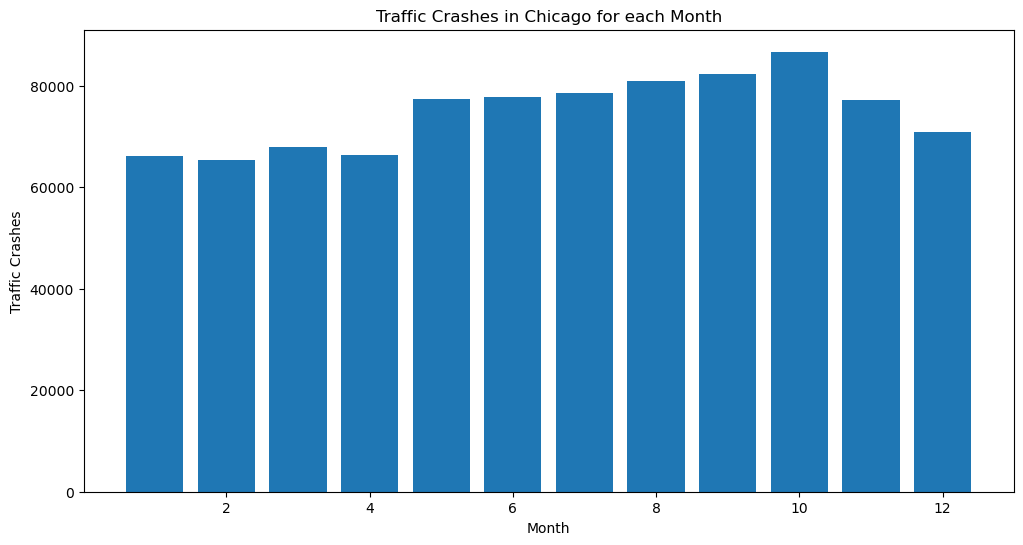

In [5]:
crash_data_filtered["CRASH_DATE"] = pd.to_datetime(crash_data_filtered["CRASH_DATE"])

# group by month and count the entry
crash_by_month = crash_data_filtered.groupby(crash_data_filtered["CRASH_DATE"].dt.month).size().reset_index(name="TOTAL_CRASHES")
crash_by_month.columns = ["MONTH", "TOTAL_CRASHES"]

plt.figure(figsize=(12,6))
plt.bar(crash_by_month["MONTH"], crash_by_month["TOTAL_CRASHES"])
plt.title("Traffic Crashes in Chicago for each Month")
plt.xlabel("Month")
plt.ylabel("Traffic Crashes")
plt.show()

#### We find number of crashes increase from January to October then decrease from October to December. Because crash number is different for each month, we analyze impact of NBA Games on Chicago Traffic Accidents for each month. The NBA season typically starts in October and ends in April of the following year, with games in Chicago concluding in April. We focus crashes from October to April.

#### Considering the impact of COVID-19 during 2020-2021, I have excluded traffic crash data from these years.  NBA games generally begin at 7:00 PM, with gates opening at 5:30 PM, and end normally at 9:30PM. Therefore, I compare the period between 17 PM to 18:59 PM and 21 PM to 23:59 PM on game days and non-game days. To ensure data consistency, I analyze data only from October to April for the years 2017-2019 and 2022-2024, focusing on the CRASH_HOUR between 17:00 to 18:59 and 21:00 to 23:59 time window. 

In [6]:
filter_years = [2017, 2018, 2019, 2022, 2023, 2024]
filter_months = {10, 11, 12, 1, 2, 3, 4}
crash_data_filtered = crash_data_filtered[
    # filter years 2017-2019 and 2022-2024
    (crash_data_filtered["CRASH_DATE"].apply(lambda x: x.year in filter_years)) &  
    # filter month from October to April
    (crash_data_filtered["CRASH_DATE"].apply(lambda x: x.month in filter_months)) &
    (
        # don't need months 1, 2, 3, 4 for the year 2017
        ~((crash_data_filtered["CRASH_DATE"].apply(lambda x: x.year == 2017)) &
          (crash_data_filtered["CRASH_DATE"].apply(lambda x: x.month in {1, 2, 3, 4}))
        )
    )
]

# filter crash hour between 17:00 to 18:59PM  and 21:00 to 23:59PM
crash_data_filtered = crash_data_filtered[
    (((crash_data_filtered["CRASH_HOUR"] >= 17) & (crash_data_filtered["CRASH_HOUR"] <= 18)) |
     ((crash_data_filtered["CRASH_HOUR"] >= 21) & (crash_data_filtered["CRASH_HOUR"] <= 23)))
]

# reset index for my new filtered dateframe
crash_data_filtered = crash_data_filtered.reset_index(drop=True)
crash_data_filtered

,CRASH_DATE,CRASH_HOUR,WEATHER_CONDITION,LATITUDE,LONGITUDE
0,2017-10-01,17,CLEAR,41.909747,-87.689812
1,2017-10-01,17,CLEAR,41.721369,-87.643065
2,2017-10-01,17,CLEAR,41.998218,-87.660695
3,2017-10-01,17,CLEAR,41.968794,-87.684105
4,2017-10-01,17,CLEAR,41.933757,-87.705849
...,...,...,...,...,...
73308,2024-11-26,23,CLEAR,41.916840,-87.756036
73309,2024-11-26,23,CLEAR,41.990951,-87.693184
73310,2024-11-26,23,CLEAR,41.931552,-87.736750
73311,2024-11-26,23,CLEAR,41.783630,-87.623875


#### Also filter NBA dataframe to only contain years 2017-2019 and 2022-2024

In [7]:
nba_df_filtered = nba_df[
    # filter years 2017-2019 and 2022-2024
    (nba_df["GAME_DATE"].apply(lambda x: x.year in filter_years))
]
nba_df_filtered = nba_df_filtered.reset_index(drop=True)
nba_df_filtered

,GAME_DATE,MATCHUP
0,2017-10-21,CHI vs. SAS
1,2017-10-26,CHI vs. ATL
2,2017-10-28,CHI vs. OKC
3,2017-11-04,CHI vs. NOP
4,2017-11-10,CHI vs. IND
...,...,...
212,2024-11-17,CHI vs. HOU
213,2024-11-22,CHI vs. ATL
214,2024-11-23,CHI vs. MEM
215,2024-11-29,CHI vs. BOS


### Now group traffic crash data by CRASH_DATE, count number of crashes in that day. Check whether that day has NBA Games in Chicago and whether that day is rain.

In [8]:
# whether that day is rain
is_rain = (
    crash_data_filtered.groupby("CRASH_DATE")["WEATHER_CONDITION"]
    .apply(lambda x: 1 if "RAIN" in x.values else 0)
    .reset_index(name="IS_RAIN")
)
game_dates = set(pd.to_datetime(nba_df_filtered["GAME_DATE"]))

# whether that day is a NBA Games Day
is_gameday = (
    crash_data_filtered.groupby("CRASH_DATE").size()
    .reset_index(name="CRASH_NUM") 
)
is_gameday["IS_GAMEDAY"] = is_gameday["CRASH_DATE"].apply(
    lambda x: 1 if x in game_dates else 0
)

# merge them
crash_by_date = is_gameday.merge(is_rain, on="CRASH_DATE")
crash_by_date["MONTH"] = crash_by_date["CRASH_DATE"].apply(lambda x: x.month)
crash_by_date

,CRASH_DATE,CRASH_NUM,IS_GAMEDAY,IS_RAIN,MONTH
0,2017-10-01,48,0,0,10
1,2017-10-02,62,0,0,10
2,2017-10-03,78,0,1,10
3,2017-10-04,56,0,0,10
4,2017-10-05,72,0,1,10
...,...,...,...,...,...
1113,2024-11-22,85,1,0,11
1114,2024-11-23,67,1,0,11
1115,2024-11-24,47,0,0,11
1116,2024-11-25,52,0,0,11


#### Draw a box plot categorizing crashes by whether it's an NBA game day

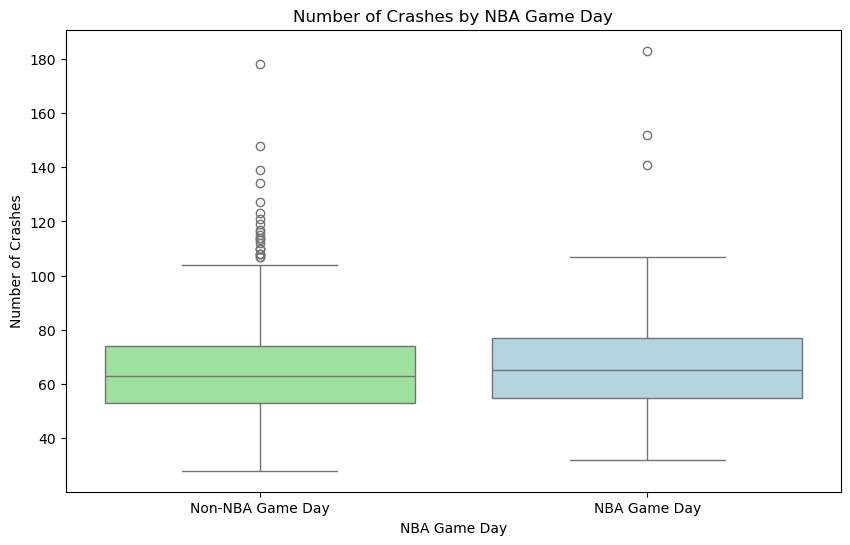

In [9]:
temp = crash_by_date.copy()
temp["IS_GAMEDAY"] = temp["IS_GAMEDAY"].map({1: "Yes", 0: "No"})

# create box plot
plt.figure(figsize=(10,6))
sns.boxplot(
    data=temp, 
    x="IS_GAMEDAY", 
    y="CRASH_NUM", 
    hue="IS_GAMEDAY",
    palette=["lightgreen", "lightblue"],
    legend=False
)

plt.title("Number of Crashes by NBA Game Day")
plt.xlabel("NBA Game Day")
plt.ylabel("Number of Crashes")
plt.xticks([0, 1], ["Non-NBA Game Day", "NBA Game Day"])
plt.show()

### Do an simple overall average number of crashes per day analysis

In [10]:
# separate data into NBA Games Day and Non-NBA Games Day
crash_on_nba_date = crash_by_date[crash_by_date["IS_GAMEDAY"] == 1]
crash_not_on_nba_date = crash_by_date[crash_by_date["IS_GAMEDAY"] == 0]
# in rain condition
crash_on_nba_date_rain = crash_on_nba_date[crash_on_nba_date["IS_RAIN"]==1]
crash_not_on_nba_date_rain = crash_not_on_nba_date[crash_not_on_nba_date["IS_RAIN"]==1]

game_day_crash = crash_on_nba_date["CRASH_NUM"]
non_game_day_crash = crash_not_on_nba_date["CRASH_NUM"]
game_day_crash_rain = crash_on_nba_date_rain["CRASH_NUM"]
non_game_day_crash_rain = crash_not_on_nba_date_rain["CRASH_NUM"]

summary_data = {
    "Day Type": [
        "NBA Games Day", 
        "Non-NBA Games Day", 
        "NBA Games Day (Clear)", 
        "Non-NBA Games Day (Clear)", 
        "NBA Games Day (Rain)", 
        "Non-NBA Games Day (Rain)"
    ],
    "Average Crashes per Day": [
        # get crashes comparison in three weather condition: All, Clear, and Rain
        game_day_crash.mean(),
        non_game_day_crash.mean(),
        crash_on_nba_date[crash_on_nba_date["IS_RAIN"]==0]["CRASH_NUM"].mean(),
        crash_not_on_nba_date[crash_not_on_nba_date["IS_RAIN"]==0]["CRASH_NUM"].mean(),
        game_day_crash_rain.mean(),
        non_game_day_crash_rain.mean()
    ]
}

summary_df = pd.DataFrame(summary_data)
summary_df

,Day Type,Average Crashes per Day
0,NBA Games Day,67.488372
1,Non-NBA Games Day,65.119601
2,NBA Games Day (Clear),61.973214
3,Non-NBA Games Day (Clear),61.551020
4,NBA Games Day (Rain),73.485437
5,Non-NBA Games Day (Rain),69.353511


### We found that the overall average number of crashes per day is slightly higher on NBA Game Days compared to Non-NBA Game Days. In Rainy Day, NBA Game Days in Chicago experience approximately 4 more crashes than Non-NBA Game Days. In clear weather condition, they seems similar. 

### Let's do hypothesis testing to assess whether differences in crash numbers are statistically significant.

In [11]:
# do variance test
print("Variance Equality:", levene(game_day_crash, non_game_day_crash).pvalue)
print("Variance Equality in Rainy Day:", levene(game_day_crash_rain, non_game_day_crash_rain).pvalue)

Variance Equality: 0.8570098843281235
Variance Equality in Rainy Day: 0.47526047973209007


#### We may use non-parametric test like Mann-Whitney U Test, but we have large sample size, parametric test like two-sample t-test may still be valid due to Central Limit Theorem. Then we still choose to use two-sample t-test. As both pvalue for variance equality test > 0.05, variances between both two dataset can be consider equal, so equal_var=True.
#### Null Hypothesis:There is no statistical significance difference in the mean number of crashes between NBA Game Days and Non-NBA Game Days.
#### Alternative Hypothesis: There is a statistical significance difference in the mean number of crashes between NBA Game Days and Non-NBA Game Days.

#### In Rain Day:
#### Null Hypothesis:There is no statistical significance difference in the mean number of crashes between NBA Game Days and Non-NBA Game Days on rainy days.
#### Alternative Hypothesis: There is a statistical significance difference in the mean number of crashes between NBA Game Days and Non-NBA Game Days on rainy days.

In [12]:
# calculate two-sample t test
result = ttest_ind(game_day_crash, non_game_day_crash, equal_var=True)
result_rain = ttest_ind(game_day_crash_rain, non_game_day_crash_rain, equal_var=True)
print(f"Overall p value with two-sample t-test:{result.pvalue}")
print(f"Overall p value in Rain with two-sample t-test:{result_rain.pvalue}")

Overall p value with two-sample t-test:0.07663636725832713
Overall p value in Rain with two-sample t-test:0.06288037840704161


### Both p-value > significance threshold 0.05 but so close to it. For all and rain condition, we fail to reject the null hypothesis and suggests there is no statistical significance difference in the mean number of crashes between NBA Game Days and Non-NBA Game Days overall and on rainy days. But p = 0.07 and 0.06 suggests a borderline result, even if it is not strictly statistically significant at the 0.05 level, this might indicate practical significance.¶

#### Let's perform an effect size analysis. We calculate metrics that quantify the magnitude of the difference between NBA Game Days and Non-NBA Game Days. This helps assess practical significance, regardless of statistical significance. we use Cohen's d.
$$d = \frac{\mu_1 - \mu_2}{\sigma}$$

#### with Small effect: $$d=0.2$$

In [13]:
def cohens_d(x, y):
    ###########################
    ## Input: dataset x and y
    ## Output: Cohen's d for effect size of x and y
    ###########################
    mean_diff = np.mean(x) - np.mean(y)
    pool_std = np.sqrt(((len(x) - 1) * np.var(x) + (len(y) - 1) * np.var(y)) / (len(x) + len(y) - 2))
    return mean_diff / pool_std

# calculate effect size
effect_size_all = cohens_d(game_day_crash, non_game_day_crash)
effect_size_rain = cohens_d(game_day_crash_rain, non_game_day_crash_rain)

print(f"Effect Size Overall: {effect_size_all}")
print(f"Effect Size Overall in Rain: {effect_size_rain}")

Effect Size Overall: 0.13460886961413138
Effect Size Overall in Rain: 0.20571578144871905


### Overall effect size (0.134 < 0.2) is small, indicating a minor difference between the number of crashes on NBA Game Days versus Non-NBA Game Days.

### The effect size during rainy days is small to medium, suggesting a slightly larger difference between the number of crashes on NBA Game Days and Non-NBA Game Days for rainy day.

In [14]:
def bootstrap_confidence_interval(x, y, num_iterations=10000, alpha=0.05):
    ###########################
    ## Input: dataset x and y, number of bootstrap iterations, significance level for the confidence interval
    ## Output: lower and upper bounds of the confidence interval for the difference of means
    ## Function: calculate the bootstrap confidence interval for the difference in means between two datasets
    ###########################
    diff_means = []
    for _ in range(num_iterations):
        # resample dataset
        sample1 = np.random.choice(x, size=len(x), replace=True)
        sample2 = np.random.choice(y, size=len(y), replace=True)
        diff_means.append(np.mean(sample1) - np.mean(sample2))
    
    # calculate confidence interval
    ci = np.percentile(diff_means, [alpha/2 * 100, (1-alpha/2) * 100])
    return ci

# Calculate bootstrapped 95% confidence interval of mean difference
ci_all = bootstrap_confidence_interval(game_day_crash, non_game_day_crash)
ci_rain = bootstrap_confidence_interval(game_day_crash_rain, non_game_day_crash_rain)

print(f"95% confidence interval Overall: {ci_all}")
print(f"95% confidence interval Overall in Rain: {ci_rain}")

95% confidence interval Overall: [-0.28418051  5.17990033]
95% confidence interval Overall in Rain: [-0.06699617  8.82223371]


#### With 95% confidence, we are confident that the true mean difference in the number of crashes between NBA Game Days and Non-NBA Game Days in all weather conditions lies within the interval [-0.30876, 5.12078], and for rainy days, it lies within the interval [-0.17897, 8.81846].

### When combining the bootstrapped confidence intervals with the results of the two-sample t-test and Cohen's d for effect size, we observe that even though the two-sample t-test indicates no statistically significant difference in the mean number of crashes between NBA Game Days and Non-NBA Game Days, NBA Games still have a practical significance on Chicago Traffic Accidents—especially on rainy days.

### The lack of statistically significant difference might be due to our current analysis encompassing crashes across the entire Chicago area. Given Chicago's large geographic extent, the potential localized impact of NBA games at the United Center could be diluted in the broader dataset.

### To more precisely assess the NBA games' impact on traffic, we should focus our analysis on crashes specifically near the United Center, where the games are held. By narrowing our geographic scope, we can obtain a more targeted understanding of how NBA games might influence local traffic patterns and accident rates.

# Analyze crashes near United Center

### Let's analyze spatial distribution of accidents near location of NBA game - United Center
#### First define the region around the United Centre where crashes occur. We analyze crashes that occur within 2.5 km of United Centre. 1 degree of latitude equal to roughly 87 km in Chicago and longtitude equal to roughly 111 km. We choose to create a bounding box around the center because of that. latitude is 0.0287 and longtitude is 0.0225.

#### latitude and longtitude of United Centre is 41.88077010720213 and -87.67420137853237. Gain all crashes in this region from our first filter datasett crash_data_filtered.

In [15]:
uc_lat = 41.88077010720213
uc_long = -87.67420137853237

# filter crashes that occur within 2.5 km of United Centre
crash_near = crash_data_filtered[(crash_data_filtered["LATITUDE"] >= uc_lat - 0.0287) &
                   (crash_data_filtered["LATITUDE"] <= uc_lat + 0.0287) &
                   (crash_data_filtered["LONGITUDE"] >= uc_long - 0.0225) &
                   (crash_data_filtered["LONGITUDE"] <= uc_long + 0.0225)].reset_index(drop=True)

crash_near

,CRASH_DATE,CRASH_HOUR,WEATHER_CONDITION,LATITUDE,LONGITUDE
0,2017-10-02,17,CLEAR,41.893304,-87.675642
1,2017-10-02,17,CLEAR,41.853144,-87.675725
2,2017-10-02,17,CLEAR,41.909399,-87.653051
3,2017-10-03,17,CLEAR,41.889834,-87.677000
4,2017-10-03,17,CLEAR,41.903199,-87.683124
...,...,...,...,...,...
4236,2024-11-24,18,CLEAR,41.899742,-87.672346
4237,2024-11-25,17,CLEAR,41.895048,-87.667181
4238,2024-11-25,18,CLEAR,41.865051,-87.661394
4239,2024-11-25,21,CLEAR,41.884374,-87.692130


In [16]:
# group and count number of crashes within 2.5 km of United Centre
crash_near_counts = (
    crash_near.groupby("CRASH_DATE")
    .size()
    .reset_index(name="CRASH_NUM")
)
crash_by_date_near = crash_by_date.copy()
crash_by_date_near = crash_by_date_near.merge(
    crash_near_counts,
    on="CRASH_DATE",
    how="left",
    suffixes=("", "_new")
)
# replace copied CRASH_NUM
crash_by_date_near["CRASH_NUM"] = crash_by_date_near["CRASH_NUM_new"].fillna(0).astype(int)

# drop the CRASH_NUM_new column
crash_by_date_near.drop(columns=["CRASH_NUM_new"], inplace=True)
crash_by_date_near

,CRASH_DATE,CRASH_NUM,IS_GAMEDAY,IS_RAIN,MONTH
0,2017-10-01,0,0,0,10
1,2017-10-02,3,0,0,10
2,2017-10-03,6,0,1,10
3,2017-10-04,2,0,0,10
4,2017-10-05,2,0,1,10
...,...,...,...,...,...
1113,2024-11-22,2,1,0,11
1114,2024-11-23,4,1,0,11
1115,2024-11-24,1,0,0,11
1116,2024-11-25,3,0,0,11


#### Let's draw a box plot

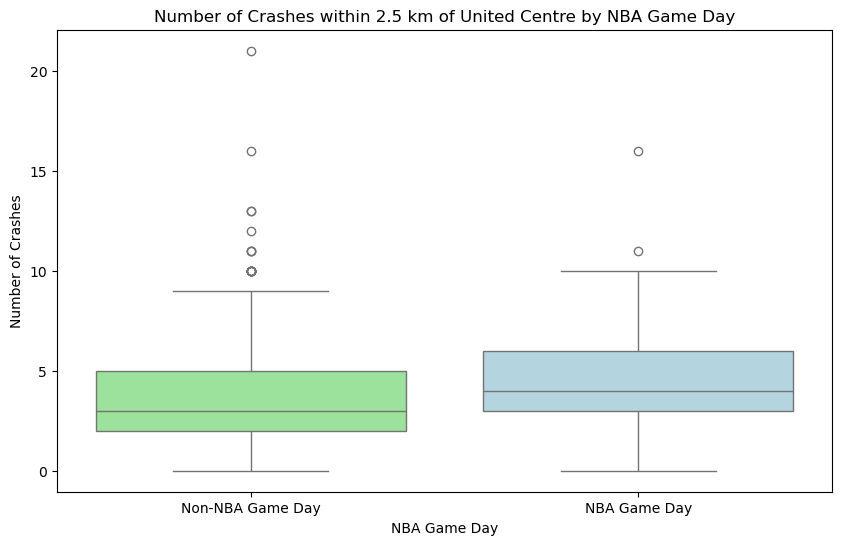

In [17]:
temp = crash_by_date_near.copy()
temp["IS_GAMEDAY"] = temp["IS_GAMEDAY"].map({1: "Yes", 0: "No"})

# create box plot
plt.figure(figsize=(10,6))
sns.boxplot(
    data=temp, 
    x="IS_GAMEDAY", 
    y="CRASH_NUM", 
    hue="IS_GAMEDAY",
    palette=["lightgreen", "lightblue"],
    legend=False
)

plt.title("Number of Crashes within 2.5 km of United Centre by NBA Game Day")
plt.xlabel("NBA Game Day")
plt.ylabel("Number of Crashes")
plt.xticks([0, 1], ["Non-NBA Game Day", "NBA Game Day"])
plt.show()

#### From the box plot, we observed an increase in the number of car accidents within 2.5 km of United Centre on NBA days.

#### Do an average number of crashes within 2.5 km of United Centre per day analysis

In [18]:
# separate data into NBA Games Day and Non-NBA Games Day
crash_on_nba_date_near = crash_by_date_near[crash_by_date_near["IS_GAMEDAY"] == 1]
crash_not_on_nba_date_near = crash_by_date_near[crash_by_date_near["IS_GAMEDAY"] == 0]
# in rain condition
crash_on_nba_date_rain_near = crash_on_nba_date_near[crash_on_nba_date_near["IS_RAIN"]==1]
crash_not_on_nba_date_rain_near = crash_not_on_nba_date_near[crash_not_on_nba_date_near["IS_RAIN"]==1]

game_day_crash_near = crash_on_nba_date_near["CRASH_NUM"]
non_game_day_crash_near = crash_not_on_nba_date_near["CRASH_NUM"]
game_day_crash_rain_near = crash_on_nba_date_rain_near["CRASH_NUM"]
non_game_day_crash_rain_near = crash_not_on_nba_date_rain_near["CRASH_NUM"]

summary_data_near = {
    "Day Type": [
        "NBA Games Day", 
        "Non-NBA Games Day", 
        "NBA Games Day (Clear)", 
        "Non-NBA Games Day (Clear)", 
        "NBA Games Day (Rain)", 
        "Non-NBA Games Day (Rain)"
    ],
    "Average Crashes per Day": [
        # get crashes comparison in three weather condition: All, Clear, and Rain
        game_day_crash_near.mean(),
        non_game_day_crash_near.mean(),
        crash_on_nba_date_near[crash_on_nba_date_near["IS_RAIN"]==0]["CRASH_NUM"].mean(),
        crash_not_on_nba_date_near[crash_not_on_nba_date_near["IS_RAIN"]==0]["CRASH_NUM"].mean(),
        game_day_crash_rain_near.mean(),
        non_game_day_crash_rain_near.mean()
    ]
}

summary_near_df = pd.DataFrame(summary_data_near)
summary_near_df

,Day Type,Average Crashes per Day
0,NBA Games Day,4.274419
1,Non-NBA Games Day,3.678848
2,NBA Games Day (Clear),3.803571
3,Non-NBA Games Day (Clear),3.463265
4,NBA Games Day (Rain),4.786408
5,Non-NBA Games Day (Rain),3.934625


### Do same two-sample t test as above

In [19]:
# first do variance test
print("Variance Equality for Crash Near UC:", levene(game_day_crash_near, non_game_day_crash_near).pvalue)
print("Variance Equality for Crash Near UC in Rainy Day:", levene(game_day_crash_rain_near, non_game_day_crash_rain_near).pvalue)

Variance Equality for Crash Near UC: 0.4737931186479898
Variance Equality for Crash Near UC in Rainy Day: 0.23793420419842504


#### Null Hypothesis:There is no statistical significance difference in the mean number of crashes within 2.5 km of United Centre between NBA Game Days and Non-NBA Game Days.
#### Alternative Hypothesis: There is a statistical significance difference in the mean number of crashes within 2.5 km of United Centre between NBA Game Days and Non-NBA Game Days.

#### In Rain Day:
#### Null Hypothesis:There is no statistical significance difference in the mean number of crashes within 2.5 km of United Centre between NBA Game Days and Non-NBA Game Days on rainy days.
#### Alternative Hypothesis: There is a statistical significance difference in the mean number of crashes within 2.5 km of United Centre between NBA Game Days and Non-NBA Game Days on rainy days.

In [20]:
# calculate two-sample t test
result_near = ttest_ind(game_day_crash_near, non_game_day_crash_near, equal_var=True)
result_rain_near = ttest_ind(game_day_crash_rain_near, non_game_day_crash_rain_near, equal_var=True)
print(f"Near UC p value with two-sample t-test:{result_near.pvalue}")
print(f"Near UC p value in Rain with two-sample t-test:{result_rain_near.pvalue}")

Near UC p value with two-sample t-test:0.001028445885029593
Near UC p value in Rain with two-sample t-test:0.00272199881285111


### Both p-value < significance threshold 0.05, we reject the null hypothesis for both all weather and rain condition. It suggests there is a statistical significance difference in the mean number of crashes within 2.5 km of United Centre between NBA Game Days and Non-NBA Game Days.

#### Let's perform an effect size analysis for crashes near United Center. We calculate metrics that quantify the magnitude of the difference of number of crashes near United Center between NBA Game Days and Non-NBA Game Days. This helps assess practical significance. we use Cohen's d.

In [21]:
# calculate effect size
effect_size_near = cohens_d(game_day_crash_near, non_game_day_crash_near)
effect_size_rain_near = cohens_d(game_day_crash_rain_near, non_game_day_crash_rain_near)

print(f"Effect Size Near UC: {effect_size_near}")
print(f"Effect Size Near UC in Rain: {effect_size_rain_near}")

Effect Size Near UC: 0.24998789109933353
Effect Size Near UC in Rain: 0.33231919875535576


### Both effect size > 0.2 (small to medium), indicating a slightly larger difference between the number of crashes within 2.5 km of United Centre on NBA Game Days and Non-NBA Game Days. Effect size in Rain is slight large (0.33232>0.24999), indicating rain might exacerbate the probability of a crash near the United Center

In [22]:
# Calculate bootstrapped 95% confidence interval of mean difference
ci_near = bootstrap_confidence_interval(game_day_crash_near, non_game_day_crash_near)
ci_rain_near = bootstrap_confidence_interval(game_day_crash_rain_near, non_game_day_crash_rain_near)

print(f"95% confidence interval Near UC: {ci_near}")
print(f"95% confidence interval Near UC in Rain: {ci_rain_near}")

95% confidence interval Near UC: [0.23897564 0.95260797]
95% confidence interval Near UC in Rain: [0.36177978 1.35121124]


#### With 95% confidence, we are confident that the true mean difference in the number of crashes within 2.5 km of United Centre between NBA Game Days and Non-NBA Game Days lies within the interval [0.23408084 0.9570598], and for rainy days, it lies within the interval [0.36918827 1.34181222].

### Through analysis of two-sample t-tests, effect sizes, and confidence intervals, these findings suggest a reasonable likelihood that NBA games in Chicago contribute to one additional crash near the United Center, especially in rainy days. Rain exacerbate the probability of a crash near the United Center in NBA Games Day. 

### It is important to note that our analysis specifically focuses on crashes that occur during two defined time windows: 5:00 PM to 6:59 PM and 9:00 PM to 11:59 PM. All conclusions drawn in this analysis are based on data from these periods

# Machine Learning Model - XGBoost, 

### We use Year, Month, Day in the week, Is Rain Day, Is NBA Game Day as input variable, to predict the crash category for a given day with (Year, Month, Day in the week, Is Rain Day, Is NBA Game Day) information.
### As neural network model like LSTM do not perform well in predict crash category within 2.5 km of United Center, we decide to utilize XGBoost, a powerful gradient boosting algorithm, to predict crash category for a given day. XGBoost is effective in capturing complex interactions and non-linear relationships between input features.

### we categorize crash numbers into four distinct categories, those crash numbers only count crashes during defined time windows within 2.5 km of United Center: 
#### crash number 0 to 1: Small
#### crash number 2 to 5: Mid
#### crash number 6 to 9 : Large
#### crash number >= 9 : Super Large
### Given the unpredictable nature of crashes and the difficulty in forecasting the exact number of crashes, we believe it is more feasible to predict crash categories rather than precise crash counts.

In [23]:
# category function
def do_category(crash_num):
    ###########################
    ## Input: an integer crash number
    ## Output: string representing crash category
    ## Function: categorizes crash number into four categories
    ###########################
    if 0 <= crash_num <= 1:
        return "Small"
    elif 2 <= crash_num <= 5:
        return "Mid"
    elif 6 <= crash_num <= 9:
        return "Large"
    elif 10 <= crash_num:
        return "Super Large"
    
# create data required for XGBoost model
model_df = crash_by_date_near.copy()
model_df["CRASH_CATEGORY"] = model_df["CRASH_NUM"].apply(do_category)
model_df["CRASH_DATE"] = pd.to_datetime(model_df["CRASH_DATE"])
model_df["YEAR"] = model_df["CRASH_DATE"].dt.year
model_df["DAY_IN_WEEK"] = model_df["CRASH_DATE"].dt.dayofweek
model_df["IS_GAMEDAY_RAIN"] = model_df["IS_GAMEDAY"] * model_df["IS_RAIN"]

X = model_df.drop(columns=["CRASH_DATE","CRASH_CATEGORY","CRASH_NUM"])
y = model_df["CRASH_CATEGORY"]
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=48)
model = xgb.XGBClassifier(random_state=48, eval_metric="mlogloss")
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

Train Accuracy: 0.814317673378076
Test Accuracy: 0.5625


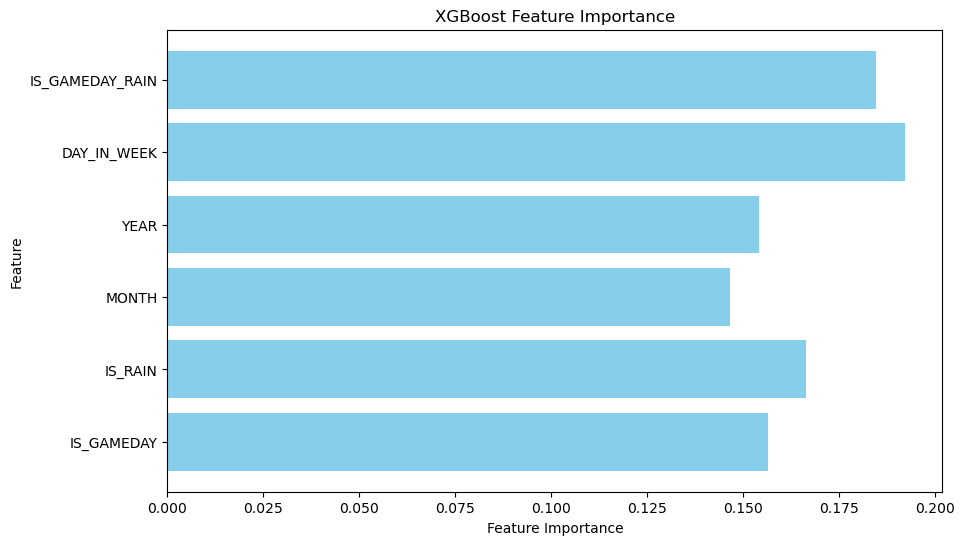

In [24]:
# Evaluate the model
y_train_pred = model.predict(X_train)

# accuracy of training set
print("Train Accuracy:", accuracy_score(y_train, y_train_pred))

y_test_pred = model.predict(X_test)

# accuracy of test set
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
# plot feature weight importance
plt.figure(figsize=(10, 6))
plt.barh(X.columns, model.feature_importances_, color="skyblue")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("XGBoost Feature Importance")
plt.show()

### When evaluating the XGBoost model on the test set, we observe a significant drop in accuracy: the model achieves 56.25% accuracy on the test set, compared to a higher 81.4% accuracy on the training set. From the XGBoost feature importance analysis, it is evident that the presence of NBA games on a given day is a crucial factor influencing the crash predictions. This finding aligns with our statement that NBA games, especially in combination with other factors like weather, contribute to an increase in crash likelihood especially near United Center.

# Conclusion

### We analyze data from October to April for the years 2017-2019 and 2022-2024, focusing on the crashes occurs between 17:00 to 18:59 and 21:00 to 23:59 time window. We observe that even though the two-sample t-test indicates no statistically significant difference in the mean number of crashes between NBA Game Days and Non-NBA Game Days, NBA Games still have a practical significance on Chicago Traffic Accidents—especially on rainy days. 
### We consider the lack of statistically significant difference might be due to our current analysis encompassing crashes across the entire Chicago metropolitan area. Given Chicago's large geographic extent, the potential localized impact of NBA games at the United Center could be diluted in the broader dataset.
### As we analyze crashes with 2.5 km of United Centre, we find a reasonable likelihood that NBA games in Chicago contribute to one additional crash near the United Center, especially in rainy days. 
### Feature importance of XGBoost also aligns with our conclusion.

### Therefore, we believe that NBA games contribute to an increase in traffic accidents in Chicago, particularly near the United Center. We also believe rain exacerbate the probability of a crash near the United Center in NBA Games Day.